This is a program which is in testing phase. We will use a linear regression ML model to give an SOC number for the flights.

In [1]:
# Import the querying module
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
all_data = pd.read_csv("ml_model_outputs/all_data.csv")

In [3]:
# Split the data into train and test sets
train_data, test_data = train_test_split(all_data, test_size=0.3, random_state=42)

In [4]:
print(f"Length train_x = {len(train_data)} \n Length train_y = {len(test_data)}")

Length train_x = 1215 
 Length train_y = 522


One-Hot-Encoding of the Operations columns

In [5]:
# ONE-HOT ENCODE
# https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
def one_hot(df, col, pre):
  encoded = pd.get_dummies(df[col], prefix=pre)
  for column in encoded:
    encoded = encoded.rename(columns={column: col + "_" + column})
  encoded['unique_data_identifier'] = df['unique_data_identifier']
  return encoded

In [6]:
# Encode Train data
train_encoded = one_hot(train_data, "activity", 'is')
final_train_x = pd.merge(train_data, train_encoded, on=["unique_data_identifier"])
final_train_y = final_train_x["soc_delta"].to_numpy()
final_train_x = final_train_x.drop(columns=["soc_delta", "id", "unique_data_identifier", "activity", "Unnamed: 0"])

# Encode Test data
test_encoded = one_hot(test_data, "activity", 'is')
final_test_x = pd.merge(test_data, test_encoded, on=["unique_data_identifier"])
final_test_y = final_test_x["soc_delta"].to_numpy()
final_test_x = final_test_x.drop(columns=["soc_delta", "id", "unique_data_identifier", "activity", "Unnamed: 0"])

In [7]:
print(f"Length test_encoded = {len(test_encoded)} \n Length train_encoded = {len(train_encoded)}")

Length test_encoded = 522 
 Length train_encoded = 1215


In [8]:
print(f"Length train_x = {len(final_train_x)} \n Length train_y = {len(final_train_y)}")

Length train_x = 1215 
 Length train_y = 1215


In [9]:
print(f"Length test_x = {len(final_test_x)} \n Length test_y = {len(final_test_y)}")

Length test_x = 522 
 Length test_y = 522


Machine Learning Model Implementation

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set model for regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=30)

# Fit model
rf_model.fit(final_train_x, final_train_y)

RandomForestRegressor(random_state=30)

In [11]:
# if there is no power on stall activities in test set, add the column with all false values
if 'activity_is_power on stall' not in final_test_x.columns:
  final_test_x.insert(loc=final_test_x.columns.get_loc('activity_is_slow flight'), column='activity_is_power on stall', value=False)

In [12]:
# Make predictions
y_pred = rf_model.predict(final_test_x)

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

# Mean Squared Error (MSE)
mse = mean_squared_error(final_test_y, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Coefficient of Determination (R-squared)
r_squared = r2_score(final_test_y, y_pred)
print(f'Coefficient of Determination (R-squared): {r_squared}')

# K-fold Cross-Validation for R-squared
cross_val_r_squared = cross_val_score(rf_model, final_train_x, final_train_y, cv=5, scoring='r2')
print(f'Cross-validated R-squared: {np.mean(cross_val_r_squared)}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(final_test_y, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(final_test_y, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds (k)
num_folds = 5  # You can adjust this based on your preference

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation for R-squared
cross_val_r_squared = cross_val_score(rf_model, final_train_x, final_train_y, cv=kf, scoring='r2')

# Display the results
print(f'K-fold Cross-validated R-squared: {np.mean(cross_val_r_squared)}')


Mean Squared Error (MSE): 1.60043314678161
Coefficient of Determination (R-squared): 0.9149286662754306
Cross-validated R-squared: 0.8564350847490617
Mean Absolute Error (MAE): 0.4474283524904215
Root Mean Squared Error (RMSE): 1.265082268780023
K-fold Cross-validated R-squared: 0.8480702447081112


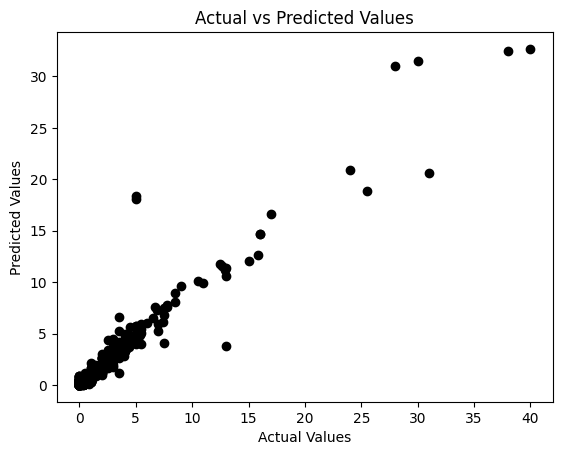

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_test_x and final_test_y are your test data
y_pred = rf_model.predict(final_test_x)

# Plot outputs
plt.scatter(final_test_y, y_pred, color="black")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

plt.show()

In [15]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display the feature importances
coeff = pd.DataFrame(list(zip(final_train_x.columns, feature_importances)), columns=['Feature', 'Importance'])
coeff.sort_values('Importance', ascending=False, inplace=True)

# Print the sorted DataFrame
print(coeff)

                        Feature  Importance
0                    time_delta    0.655485
4                 average_power    0.127090
2              average_altitude    0.102585
16          activity_is_takeoff    0.045479
8             activity_is_climb    0.021991
3                  ground_speed    0.014711
9            activity_is_cruise    0.011808
1                           soh    0.007786
5                   temperature    0.006823
7                    wind_speed    0.003622
6                    visibility    0.002046
11          activity_is_landing    0.000251
14      activity_is_slow flight    0.000183
10          activity_is_descent    0.000067
15      activity_is_steep turns    0.000034
12  activity_is_power off stall    0.000028
13   activity_is_power on stall    0.000011


In [16]:
import joblib

model_filename = 'ML_model_outputs/prescription_randomforest_model.joblib'
joblib.dump(rf_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to ML_model_outputs/prescription_randomforest_model.joblib
